In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
matplotlib.rcParams['figure.figsize'] = (22,12)
plt.style.use('fivethirtyeight')
import plotly
import plotly.express as px
import plotly.graph_objects as go

import keras
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout, BatchNormalization

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [2]:
def data_checker(dataframe):
    print(dataframe.info())
    print("\n")
    print("\n")
    print('---------------'*7)
    print(dataframe.index)
    print("\n")
    print("\n")
    print('---------------'*7)
    print('Number of rows and columns:', dataframe.shape)
    print("\n")
    print("\n")
    print('---------------'*7)
    print(dataframe.head())
    print("\n")
    print("\n")
    print('---------------'*7)
    print(dataframe.tail())
    print("\n")
    print("\n")
    print('---------------'*7)
    print('Amount of missing data:', dataframe.isnull().sum())
    print("\n")
    print("\n")
    print('---------------'*7)
    print(dataframe.describe())

In [3]:
import yfinance as yf
from yahoofinancials import YahooFinancials

KO  =     yf.download('KO', 
                      start = '2015-01-01', 
                      end = '2022-01-01', 
                      progress = False)

df = KO[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)

df.head(10)

print("There are "+ str(df[:'2020'].shape[0]) + " observations in the training data")

print("There are "+ str(df['2021':].shape[0]) + " observations in the test data")



# There are 1,511 and 252 observations in the training and test data respectively.

There are 1511 observations in the training data
There are 252 observations in the test data


In [4]:
data_checker(df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1763 entries, 2015-01-02 to 2021-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1763 non-null   float64
 1   Open       1763 non-null   float64
 2   High       1763 non-null   float64
 3   Low        1763 non-null   float64
 4   Close      1763 non-null   float64
 5   Volume     1763 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 161.0 KB
None




---------------------------------------------------------------------------------------------------------
DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2021-12-17', '2021-12-20', '2021-12-21', '2021-12-22',
               '2021-12-23', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],

In [5]:
trace1 = go.Scatter(
 x = df.index,
 y = df['Open'],
 mode = 'lines',
 name = 'Open'
)
trace2 = go.Scatter(
 x = df.index,
 y = df['High'],
 mode = 'lines',
 name = 'High'
)
trace3 = go.Scatter(
 x = df.index,
 y = df['Low'],
 mode = 'lines',
 name = 'Low'
)
trace4 = go.Scatter(
 x = df.index,
 y = df['Close'],
 mode = 'lines',
 name = 'Close'
)
trace5 = go.Scatter(
 x = df.index,
 y = df['Volume'],
 mode = 'lines',
 name = 'Volume'
)
trace6 = go.Scatter(
 x = df.index,
 y = df['Adj Close'],
 mode = 'lines',
 name = 'Adj Close'
)
layout = go.Layout(
 title = 'The Coca-Cola Company (KO), Daily Stock Prices',
 xaxis = {'title' : "Date"},
 yaxis = {'title' : 'Daily Price'}
)
fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace6], layout=layout)
fig.show()

In [6]:
# Data Preprocessing

In [7]:
def train_test(df, time_steps, for_periods):

    # create training and test set
    train = df[:'2021'].iloc[:,0:1].values
    test  = df['2021':].iloc[:,0:1].values
    train_len = len(train)
    test_len = len(test)

    # scale the data
    sc = MinMaxScaler(feature_range=(0,1))
    train_scaled = sc.fit_transform(train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps, train_len-1): 
        X_train.append(train_scaled[i-time_steps:i,0])
        y_train.append(train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((df["Adj Close"][:'2021'], df["Adj Close"]['2021':]),axis=0).values
    inputs = inputs[len(inputs)-len(test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

In [8]:
def actual_pred_plot(preds):
    
    # Plot the actual vs. prediction

    actual_pred = pd.DataFrame(columns = ['Adj Close', 'prediction'])
    actual_pred['Adj Close'] = df.loc['2021':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    plt.plot(actual_pred['Adj Close'])
    plt.plot(actual_pred['prediction'])
    plt.title('Test vs Model Prediction for 2021')
    plt.ylabel('Price', fontsize = 15)
    plt.xlabel('Date', fontsize = 15)
    plt.legend(['Test', 'Prediction'], loc = 'upper left');
    
    # RMSE
    mse = np.square(np.subtract((actual_pred['Adj Close']), actual_pred['prediction'])).mean() 
    rmse = math.sqrt(mse)
    
    return (plt.show(), print("Root Mean Square Error:\n"),  rmse)

In [9]:
X_train, y_train, X_test, sc = train_test(df, 5, 1)

In [10]:
# Modeling

In [11]:
def simple_rnn_model(X_train, y_train, X_test, sc):

    # Create a model
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences = True))
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(1)) # The time step of the output

    my_rnn_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fit the RNN model
    my_rnn_model.fit(X_train, y_train, epochs = 100, batch_size = 5, verbose = 2)
    

    # Finalizing predictions
    rnn_predictions = my_rnn_model.predict(X_test)
    rnn_predictions = sc.inverse_transform(rnn_predictions)

    return my_rnn_model, rnn_predictions 

In [12]:
my_rnn_model, rnn_predictions = simple_rnn_model(X_train, y_train, X_test, sc)


Epoch 1/100


2022-02-07 11:37:17.431997: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


352/352 - 3s - loss: 0.0075 - 3s/epoch - 9ms/step
Epoch 2/100
352/352 - 1s - loss: 9.1552e-04 - 1s/epoch - 3ms/step
Epoch 3/100
352/352 - 1s - loss: 7.0461e-04 - 1s/epoch - 4ms/step
Epoch 4/100
352/352 - 1s - loss: 5.3047e-04 - 1s/epoch - 4ms/step
Epoch 5/100
352/352 - 1s - loss: 5.4260e-04 - 1s/epoch - 4ms/step
Epoch 6/100
352/352 - 1s - loss: 4.8238e-04 - 1s/epoch - 4ms/step
Epoch 7/100
352/352 - 1s - loss: 6.2249e-04 - 1s/epoch - 4ms/step
Epoch 8/100
352/352 - 1s - loss: 5.5755e-04 - 1s/epoch - 3ms/step
Epoch 9/100
352/352 - 1s - loss: 5.9036e-04 - 1s/epoch - 3ms/step
Epoch 10/100
352/352 - 1s - loss: 4.6712e-04 - 1s/epoch - 3ms/step
Epoch 11/100
352/352 - 1s - loss: 4.5730e-04 - 1s/epoch - 4ms/step
Epoch 12/100
352/352 - 1s - loss: 4.9018e-04 - 1s/epoch - 4ms/step
Epoch 13/100
352/352 - 1s - loss: 5.4624e-04 - 1s/epoch - 3ms/step
Epoch 14/100
352/352 - 1s - loss: 4.0562e-04 - 1s/epoch - 3ms/step
Epoch 15/100
352/352 - 1s - loss: 4.6075e-04 - 1s/epoch - 4ms/step
Epoch 16/100
352/352

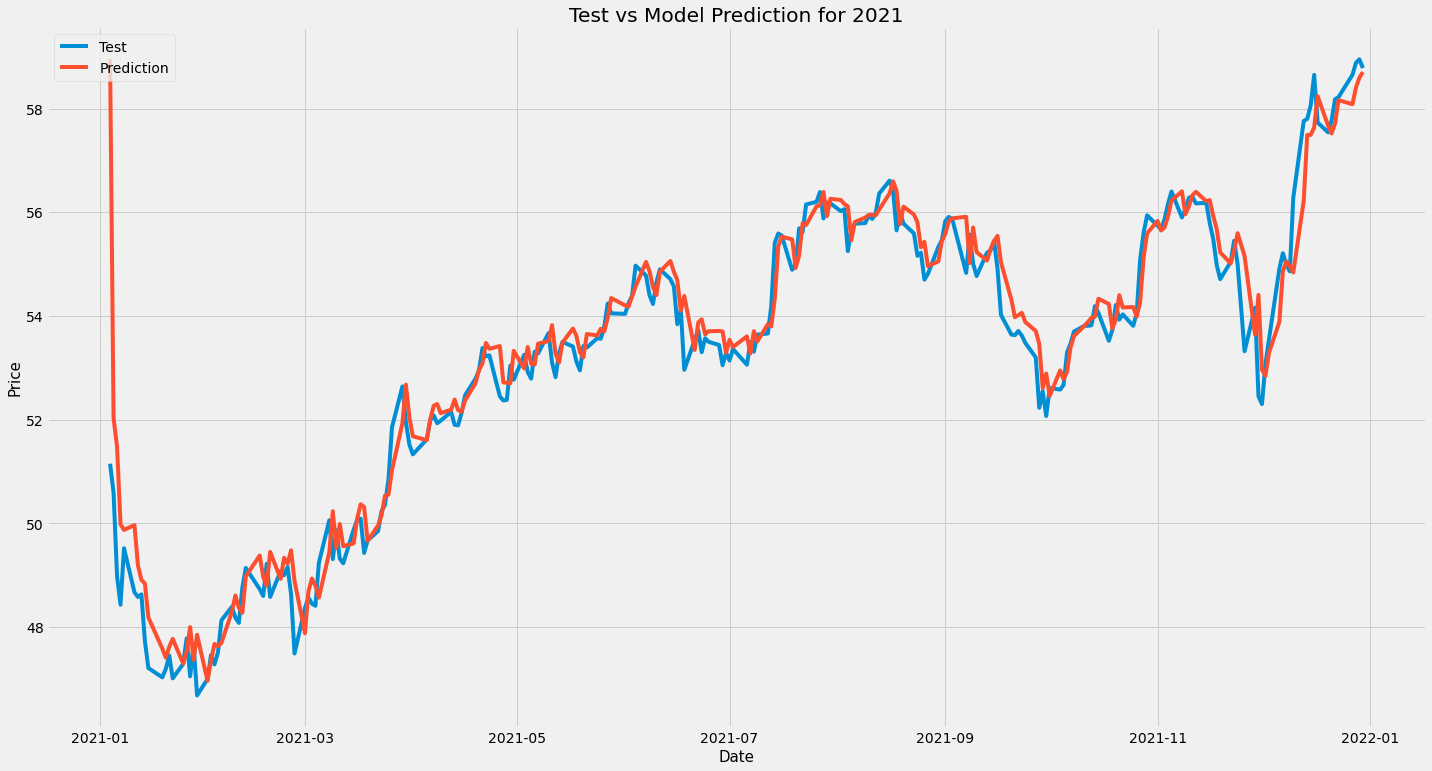

Root Mean Square Error:



(None, None, 0.730677333813066)

In [13]:
actual_pred_plot(rnn_predictions) 

In [14]:
def LSTM_model(X_train, y_train, X_test, sc):
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1],1), activation = 'relu'))

    my_LSTM_model.add(LSTM(units = 50, activation = 'relu'))
    my_LSTM_model.add(Dense(units = 1))

    # Compiling
    my_LSTM_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    # Fitting to the training set
    my_LSTM_model.fit(X_train, y_train, epochs = 100, batch_size = 5, verbose = 2)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

In [15]:
my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)

Epoch 1/100
352/352 - 5s - loss: 0.0190 - 5s/epoch - 14ms/step
Epoch 2/100
352/352 - 2s - loss: 0.0010 - 2s/epoch - 6ms/step
Epoch 3/100
352/352 - 2s - loss: 0.0010 - 2s/epoch - 6ms/step
Epoch 4/100
352/352 - 2s - loss: 9.6118e-04 - 2s/epoch - 6ms/step
Epoch 5/100
352/352 - 2s - loss: 0.0011 - 2s/epoch - 6ms/step
Epoch 6/100
352/352 - 2s - loss: 8.5224e-04 - 2s/epoch - 6ms/step
Epoch 7/100
352/352 - 2s - loss: 7.7317e-04 - 2s/epoch - 6ms/step
Epoch 8/100
352/352 - 2s - loss: 8.0925e-04 - 2s/epoch - 6ms/step
Epoch 9/100
352/352 - 2s - loss: 6.7443e-04 - 2s/epoch - 6ms/step
Epoch 10/100
352/352 - 2s - loss: 6.5921e-04 - 2s/epoch - 6ms/step
Epoch 11/100
352/352 - 2s - loss: 5.8971e-04 - 2s/epoch - 6ms/step
Epoch 12/100
352/352 - 2s - loss: 5.9053e-04 - 2s/epoch - 6ms/step
Epoch 13/100
352/352 - 2s - loss: 5.8193e-04 - 2s/epoch - 6ms/step
Epoch 14/100
352/352 - 2s - loss: 5.4227e-04 - 2s/epoch - 5ms/step
Epoch 15/100
352/352 - 2s - loss: 5.7584e-04 - 2s/epoch - 5ms/step
Epoch 16/100
352/35

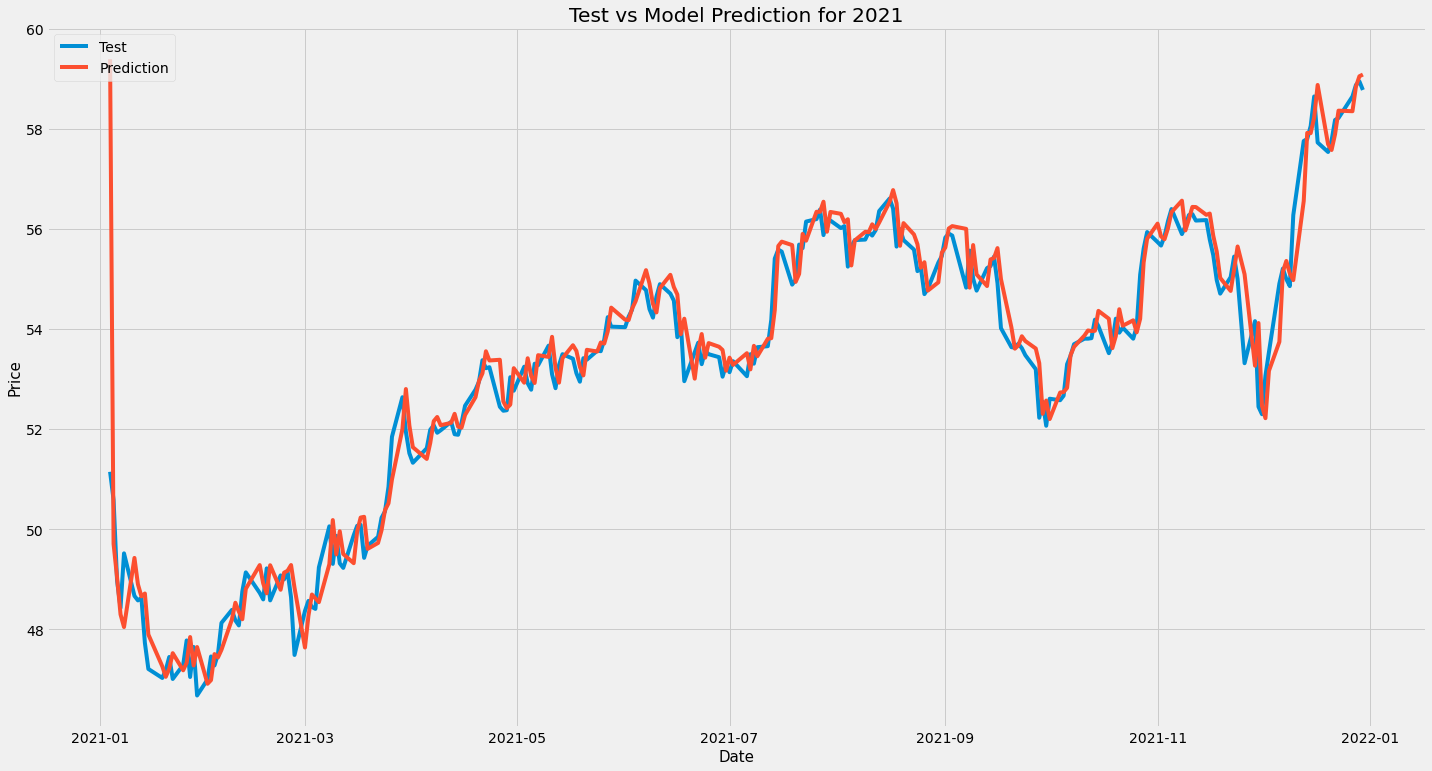

Root Mean Square Error:



(None, None, 0.712485048638487)

In [16]:
actual_pred_plot(LSTM_prediction)  

In [17]:
def LSTM_model_regularization(X_train, y_train, X_test, sc):
    # create a model
    
    # The LSTM architecture
    my_LSTM_model_regularization = Sequential()
    my_LSTM_model_regularization.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1],1), activation = 'relu'))
    
    my_LSTM_model_regularization.add(LSTM(units = 50, activation = 'relu'))
    my_LSTM_model_regularization.add(Dropout(0.2))
    
    my_LSTM_model_regularization.add(Dense(units = 1))

    # Compiling
    my_LSTM_model_regularization.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fitting to the training set
    my_LSTM_model_regularization.fit(X_train, y_train, epochs = 100, batch_size = 5, verbose = 2)

    LSTM_prediction_regularization = my_LSTM_model_regularization.predict(X_test)
    LSTM_prediction_regularization = sc.inverse_transform(LSTM_prediction_regularization)

    return my_LSTM_model_regularization, LSTM_prediction_regularization

In [18]:
my_LSTM_model_regularization, LSTM_prediction_regularization = LSTM_model_regularization(X_train, y_train, X_test, sc)

Epoch 1/100
352/352 - 4s - loss: 0.0212 - 4s/epoch - 13ms/step
Epoch 2/100
352/352 - 2s - loss: 0.0058 - 2s/epoch - 6ms/step
Epoch 3/100
352/352 - 2s - loss: 0.0049 - 2s/epoch - 6ms/step
Epoch 4/100
352/352 - 2s - loss: 0.0042 - 2s/epoch - 6ms/step
Epoch 5/100
352/352 - 2s - loss: 0.0038 - 2s/epoch - 5ms/step
Epoch 6/100
352/352 - 2s - loss: 0.0033 - 2s/epoch - 5ms/step
Epoch 7/100
352/352 - 2s - loss: 0.0031 - 2s/epoch - 5ms/step
Epoch 8/100
352/352 - 2s - loss: 0.0027 - 2s/epoch - 5ms/step
Epoch 9/100
352/352 - 2s - loss: 0.0025 - 2s/epoch - 5ms/step
Epoch 10/100
352/352 - 2s - loss: 0.0025 - 2s/epoch - 6ms/step
Epoch 11/100
352/352 - 2s - loss: 0.0022 - 2s/epoch - 5ms/step
Epoch 12/100
352/352 - 2s - loss: 0.0023 - 2s/epoch - 5ms/step
Epoch 13/100
352/352 - 2s - loss: 0.0023 - 2s/epoch - 5ms/step
Epoch 14/100
352/352 - 2s - loss: 0.0023 - 2s/epoch - 5ms/step
Epoch 15/100
352/352 - 2s - loss: 0.0023 - 2s/epoch - 5ms/step
Epoch 16/100
352/352 - 2s - loss: 0.0023 - 2s/epoch - 6ms/step


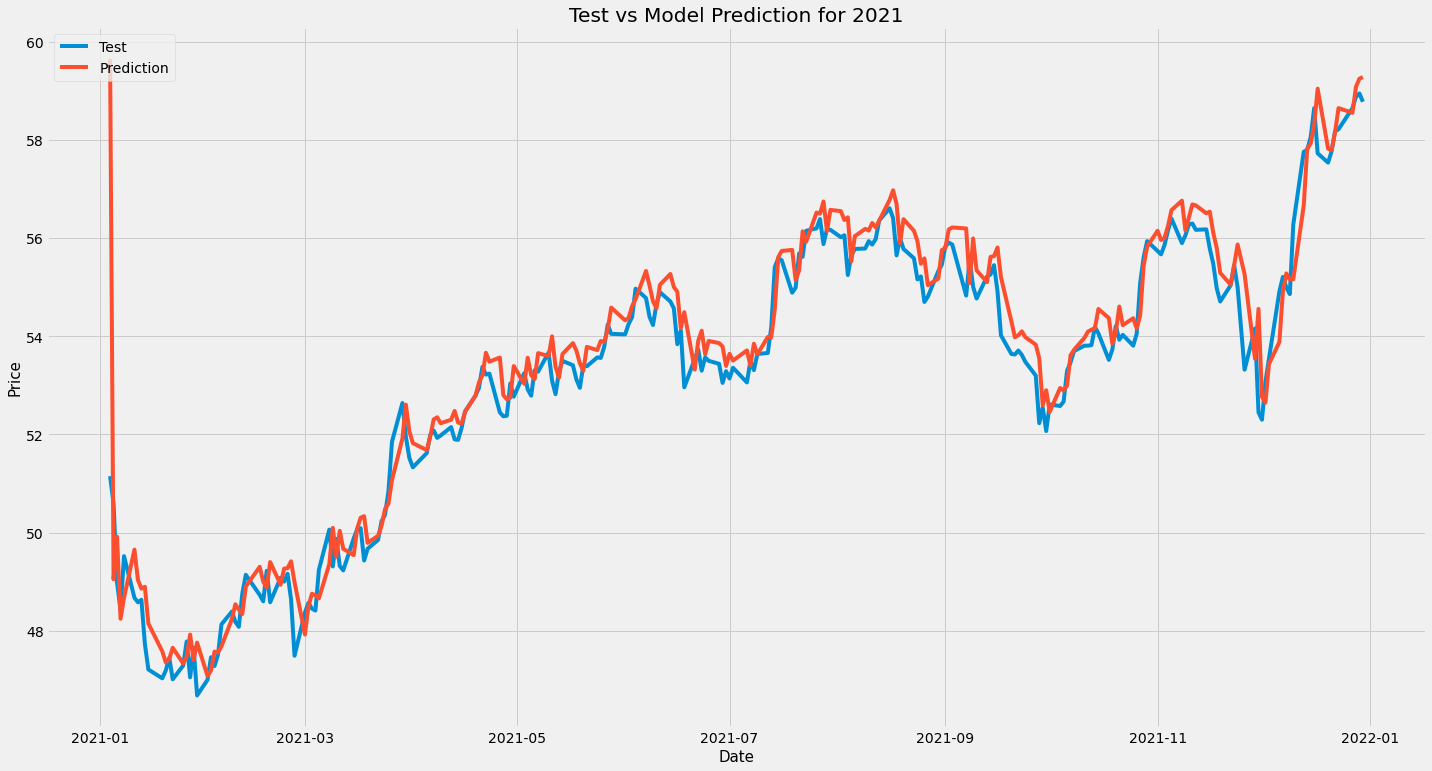

Root Mean Square Error:



(None, None, 0.7717607788905994)

In [19]:
actual_pred_plot(LSTM_prediction_regularization) 

In [20]:
def GRU_model(X_train, y_train, X_test, sc):
    
    # Create the model
    my_GRU_model = Sequential()

    # First GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units = 50, return_sequences = True, input_shape = (X_train.shape[1],1), activation = 'relu'))

    my_GRU_model.add(GRU(units = 50, activation = 'relu'))
    
    my_GRU_model.add(Dense(units = 1))

    # Compiling the RNN
    my_GRU_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fitting to the training set
    my_GRU_model.fit(X_train, y_train, epochs = 100, batch_size = 5, verbose = 2)

    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)

    return my_GRU_model, GRU_prediction

In [21]:
my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)

Epoch 1/100
352/352 - 5s - loss: 0.0127 - 5s/epoch - 13ms/step
Epoch 2/100
352/352 - 2s - loss: 7.0181e-04 - 2s/epoch - 6ms/step
Epoch 3/100
352/352 - 2s - loss: 7.1237e-04 - 2s/epoch - 6ms/step
Epoch 4/100
352/352 - 2s - loss: 6.0057e-04 - 2s/epoch - 6ms/step
Epoch 5/100
352/352 - 2s - loss: 5.1987e-04 - 2s/epoch - 6ms/step
Epoch 6/100
352/352 - 2s - loss: 5.0922e-04 - 2s/epoch - 6ms/step
Epoch 7/100
352/352 - 2s - loss: 5.0786e-04 - 2s/epoch - 6ms/step
Epoch 8/100
352/352 - 2s - loss: 4.6185e-04 - 2s/epoch - 6ms/step
Epoch 9/100
352/352 - 2s - loss: 5.5318e-04 - 2s/epoch - 6ms/step
Epoch 10/100
352/352 - 2s - loss: 4.7676e-04 - 2s/epoch - 6ms/step
Epoch 11/100
352/352 - 2s - loss: 4.3740e-04 - 2s/epoch - 6ms/step
Epoch 12/100
352/352 - 2s - loss: 4.2840e-04 - 2s/epoch - 6ms/step
Epoch 13/100
352/352 - 2s - loss: 4.0318e-04 - 2s/epoch - 6ms/step
Epoch 14/100
352/352 - 2s - loss: 4.1338e-04 - 2s/epoch - 6ms/step
Epoch 15/100
352/352 - 2s - loss: 4.4294e-04 - 2s/epoch - 6ms/step
Epoch 1

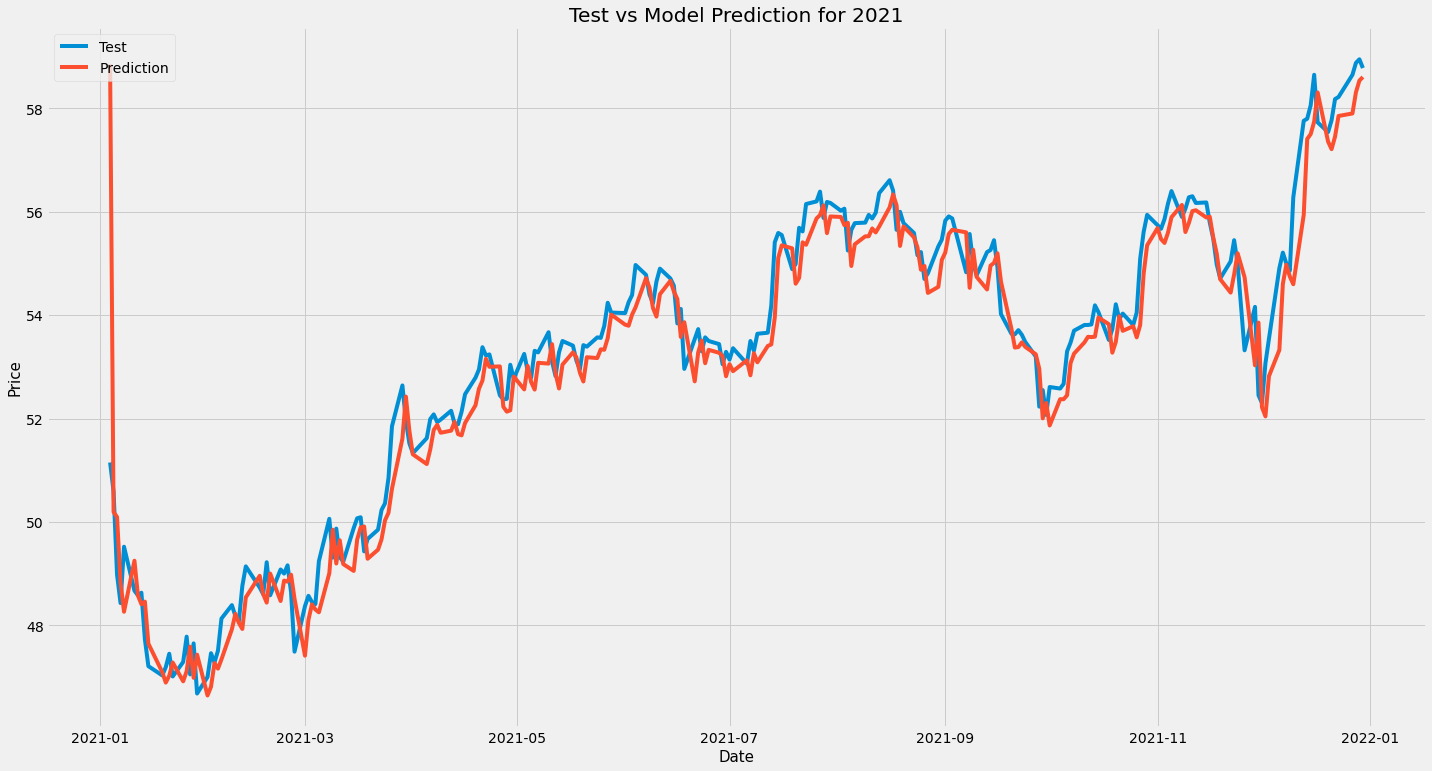

Root Mean Square Error:



(None, None, 0.7347192024700618)

In [22]:
actual_pred_plot(GRU_prediction) 

In [23]:
def GRU_model_regularization(X_train, y_train, X_test, sc):
    
    # Creating the model
    my_GRU_model_regularization = Sequential()

    # First GRU layer with Dropout regularisation
    my_GRU_model_regularization.add(GRU(units = 50, return_sequences = True, input_shape = (X_train.shape[1],1), activation = 'relu'))
    my_GRU_model_regularization.add(Dropout(0.2))

    # Second GRU layer
    my_GRU_model_regularization.add(GRU(units = 50, return_sequences = True, activation ='relu'))
    my_GRU_model_regularization.add(Dropout(0.2))
    
    # Third GRU layer
    my_GRU_model_regularization.add(GRU(units = 50, return_sequences = True, activation ='relu'))
    my_GRU_model_regularization.add(Dropout(0.2))

    # Fourth GRU layer
    my_GRU_model_regularization.add(GRU(units = 50, activation = 'relu'))
    my_GRU_model_regularization.add(Dropout(0.2))

    # The output layer
    my_GRU_model_regularization.add(Dense(units = 1))

    # Compiling the RNN
    my_GRU_model_regularization.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fitting to the training set
    my_GRU_model_regularization.fit(X_train, y_train, epochs = 100, batch_size = 5, verbose = 2)

    GRU_predictions_regularization = my_GRU_model_regularization.predict(X_test)
    GRU_predictions_regularization = sc.inverse_transform(GRU_predictions_regularization)

    return my_GRU_model_regularization, GRU_predictions_regularization

In [24]:
my_GRU_model_regularization, GRU_predictions_regularization = GRU_model_regularization(X_train, y_train, X_test, sc)

Epoch 1/100
352/352 - 8s - loss: 0.0171 - 8s/epoch - 24ms/step
Epoch 2/100
352/352 - 4s - loss: 0.0054 - 4s/epoch - 10ms/step
Epoch 3/100
352/352 - 4s - loss: 0.0045 - 4s/epoch - 11ms/step
Epoch 4/100
352/352 - 4s - loss: 0.0041 - 4s/epoch - 11ms/step
Epoch 5/100
352/352 - 4s - loss: 0.0037 - 4s/epoch - 11ms/step
Epoch 6/100
352/352 - 4s - loss: 0.0035 - 4s/epoch - 11ms/step
Epoch 7/100
352/352 - 4s - loss: 0.0032 - 4s/epoch - 11ms/step
Epoch 8/100
352/352 - 4s - loss: 0.0031 - 4s/epoch - 10ms/step
Epoch 9/100
352/352 - 4s - loss: 0.0028 - 4s/epoch - 10ms/step
Epoch 10/100
352/352 - 4s - loss: 0.0028 - 4s/epoch - 11ms/step
Epoch 11/100
352/352 - 4s - loss: 0.0024 - 4s/epoch - 11ms/step
Epoch 12/100
352/352 - 4s - loss: 0.0027 - 4s/epoch - 11ms/step
Epoch 13/100
352/352 - 4s - loss: 0.0024 - 4s/epoch - 10ms/step
Epoch 14/100
352/352 - 4s - loss: 0.0022 - 4s/epoch - 11ms/step
Epoch 15/100
352/352 - 4s - loss: 0.0021 - 4s/epoch - 11ms/step
Epoch 16/100
352/352 - 4s - loss: 0.0024 - 4s/epo

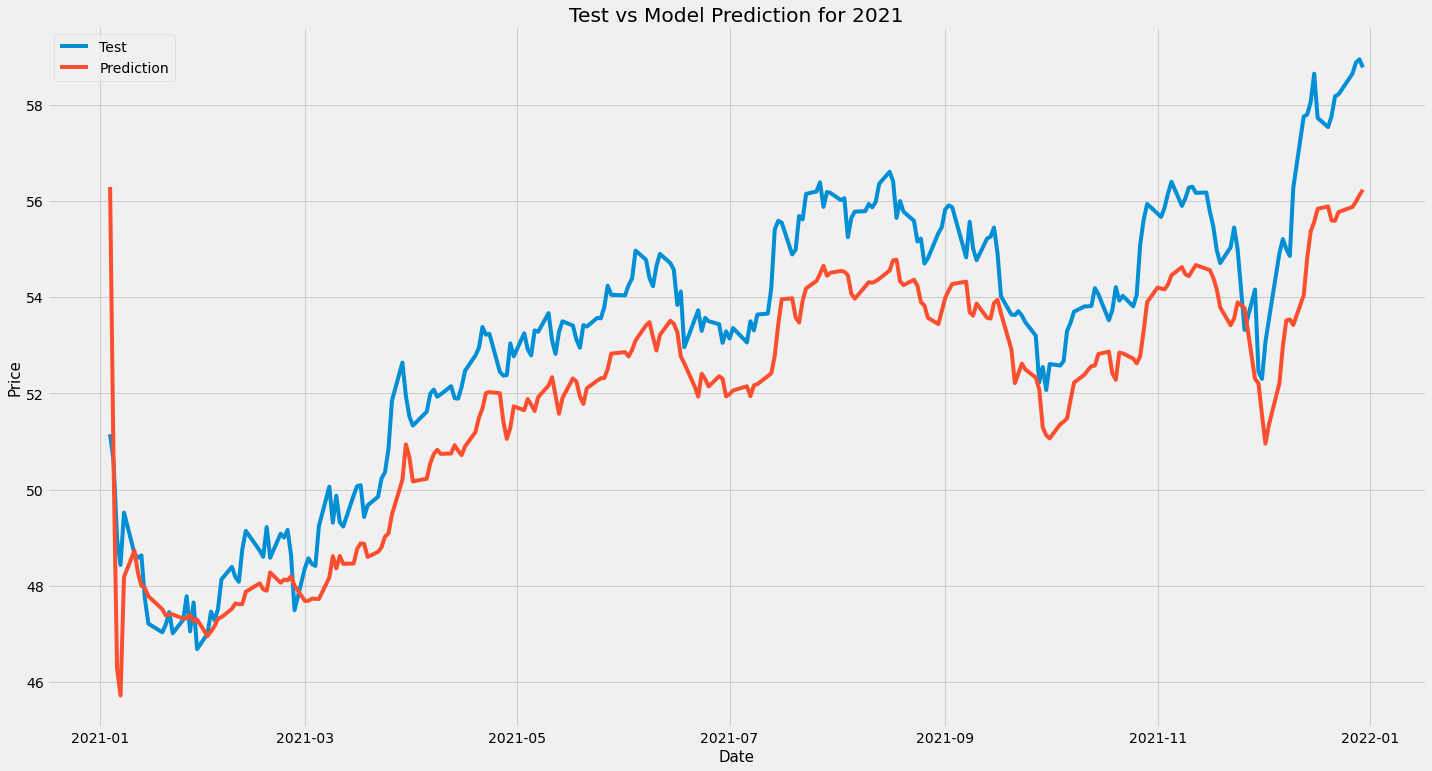

Root Mean Square Error:



(None, None, 1.507644588777203)

In [25]:
actual_pred_plot(GRU_predictions_regularization)  